In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
# Load the data
data = pd.read_csv('generated_data.csv')

<Axes: xlabel='Rating'>

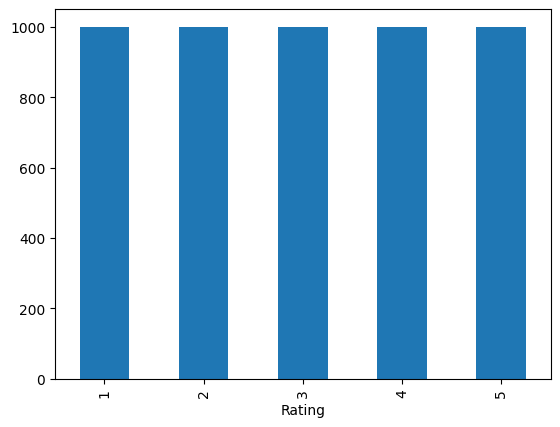

In [16]:
data['Rating'].value_counts().plot(kind='bar')

In [17]:
# split data into patients data doctors data and ratings

patients = data.columns[1:8]
data_patients = data[patients] # patients data
doctors = data.columns[8:15]
data_doctors = data[doctors] # doctors data
ratings = data.columns[15:]
data_ratings = data[ratings] # ratings

In [18]:
data_patients.describe()

,Patient ID,Patient Age,Patient Gender,Patient Health Condition,Patient Location,Previous Doctor Type,Last Appointment (Days)
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000
mean,500.500000,39.246000,0.468000,49.963000,50.104000,50.42700,154.58100
std,288.703862,23.130683,0.499025,29.005308,28.849812,29.22635,87.24094
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.00000
25%,250.750000,19.000000,0.000000,25.000000,25.000000,25.75000,82.00000
50%,500.500000,40.000000,0.000000,50.000000,50.000000,50.50000,161.00000
75%,750.250000,59.000000,1.000000,76.000000,75.000000,76.00000,229.00000
max,1000.000000,80.000000,1.000000,100.000000,100.000000,100.00000,300.00000


In [19]:
data_doctors.describe()

,Doctor ID,Doctor Age,Doctor Location,Doctor Type,Experience (Years),Patients in Lifetime,Patients in Queue
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2498.654400,71.246000,49.663600,50.320400,18.025305,1500.137885,29.982003
std,290.606507,32.359402,35.219184,29.200436,9.141134,710.360141,14.192166
min,2000.000000,0.000000,-45.000000,0.000000,0.011898,400.049858,8.011894
25%,2245.000000,48.000000,23.000000,25.000000,10.549263,949.375426,18.933282
50%,2496.000000,71.000000,49.000000,50.000000,18.089571,1504.389334,29.951434
75%,2755.250000,94.000000,76.000000,76.000000,25.482056,2049.511207,40.985482
max,2999.000000,144.000000,150.000000,100.000000,35.986199,2599.769044,51.999654


In [20]:
data_ratings.describe()

,Rating
count,5000.000000
mean,3.000000
std,1.414355
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [21]:
# create datsets from the data
data_patients_train=data_patients.values[:4000]
data_patients_test=data_patients.values[4000:]

data_doctors_train=data_doctors.values[:4000]
data_doctors_test=data_doctors.values[4000:]

data_ratings_train=data_ratings.values[:4000]
data_ratings_test=data_ratings.values[4000:]

# patients data
train_dataset = tf.data.Dataset.from_tensor_slices((data_patients_train, data_doctors_train))
test_dataset = tf.data.Dataset.from_tensor_slices((data_patients_test, data_doctors_test))

# ratings data

train_labels = tf.data.Dataset.from_tensor_slices(data_ratings_train)
test_labels = tf.data.Dataset.from_tensor_slices(data_ratings_test)

# zip the datasets

train_dataset = tf.data.Dataset.zip((train_dataset, train_labels))
test_dataset = tf.data.Dataset.zip((test_dataset, test_labels))

# shuffle the datasets
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [22]:
train_dataset

<_BatchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.int64, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [23]:
test_dataset

<_BatchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.int64, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [24]:
def create_model(hp):
    lr=hp.Float('learning_rate',min_value=1e-6,max_value=1e-1,sampling='LOG',default=1e-3)
    unit1=hp.Int('unit1',min_value=32,max_value=128,step=32)
    unit2=hp.Int('unit2',min_value=32,max_value=64,step=32)
    unit3=hp.Int('unit3',min_value=32,max_value=64,step=32)
    unit4=hp.Int('unit4',min_value=16,max_value=32,step=32)
    input1=tf.keras.layers.Input(shape=(7,))
    input2=tf.keras.layers.Input(shape=(7,))

    a=tf.keras.layers.Dense(unit1,activation='relu')(input1)
    b=tf.keras.layers.Dense(unit1,activation='relu')(input2)

    b=tf.keras.layers.Dense(unit2,activation='relu')(b)
    a=tf.keras.layers.Dense(unit2,activation='relu')(a)

    a=tf.keras.layers.Dense(unit3,activation='relu')(a)
    b=tf.keras.layers.Dense(unit3,activation='relu')(b)

    c=tf.keras.layers.add([a,b])

    c=tf.keras.layers.Dense(unit4,activation='relu')(c)
    c=tf.keras.layers.Dense(6,activation='softmax')(c)

    model=tf.keras.models.Model(inputs=[input1,input2],outputs=c)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    return model

In [25]:
# tune the hyperparameters

import keras_tuner as kt

tuner=kt.Hyperband(create_model,objective='val_accuracy',max_epochs=10,overwrite=True,project_name='doctor_rating')

In [26]:
tuner.search(train_dataset,epochs=10,validation_data=test_dataset)

Trial 30 Complete [00h 00m 03s]
val_accuracy: 0.9549999833106995

Best val_accuracy So Far: 0.9710000157356262
Total elapsed time: 00h 01m 01s


In [27]:
model = tuner.get_best_models()[0]

In [28]:
# plot the model

tf.keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
# import the callbacks

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

checkpoint=ModelCheckpoint('recommender-ensemble.h5',monitor='loss',save_best_only=True)

earlystop=EarlyStopping(monitor='loss',patience=10)

reduce_lr=ReduceLROnPlateau(monitor='loss',factor=0.2,patience=1,min_lr=1e-6)


In [30]:
model.fit(train_dataset,epochs=10,validation_data=test_dataset,callbacks=[checkpoint,earlystop,reduce_lr])

Epoch 1/10


125/125 [==============================] - 1s 2ms/step - loss: 0.9910 - accuracy: 0.8808 - val_loss: 1.2734 - val_accuracy: 0.8060 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6437 - accuracy: 0.9045 - val_loss: 0.7383 - val_accuracy: 0.8630 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 0s 1ms/step - loss: 0.5620 - accuracy: 0.9105 - val_loss: 0.5659 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 0s 1ms/step - loss: 0.5831 - accuracy: 0.9105 - val_loss: 0.7413 - val_accuracy: 0.8520 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 0s 1ms/step - loss: 0.6557 - accuracy: 0.9147 - val_loss: 0.4757 - val_accuracy: 0.8910 - lr: 2.0000e-04
Epoch 6/10
125/125 [==============================] - 0s 1ms/step - loss: 1.0397 - accuracy: 0.8605 - val_loss: 0.7144 - val_accuracy: 0.8470 - lr: 4.0000e-05
Epoch 7/10
125/125 [==============================] - 0s 1ms/step - loss:

In [31]:
# test the model
y_pred=model.predict(test_dataset)

32/32 [==============================] - 0s 831us/step


In [32]:
y_pred=np.array(y_pred)

In [33]:
y_pred=np.argmax(y_pred,axis=1)

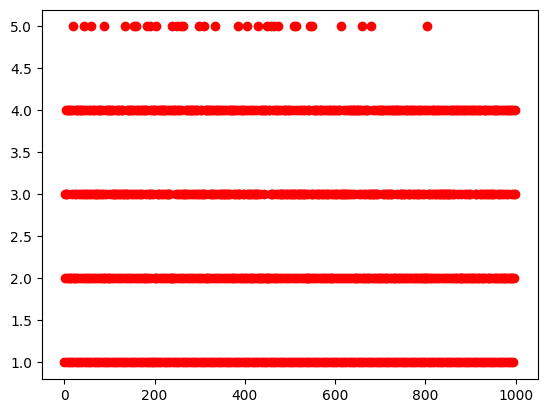

In [34]:
plt.scatter(range(len(y_pred)),y_pred,color='red')

In [35]:
y_true=np.fromiter(test_labels.as_numpy_iterator(),dtype=np.int32)

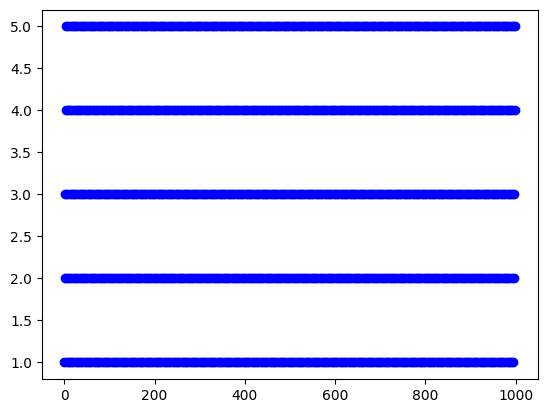

In [36]:
plt.scatter(range(len(y_pred)),y_true,color='blue')

<Axes: >

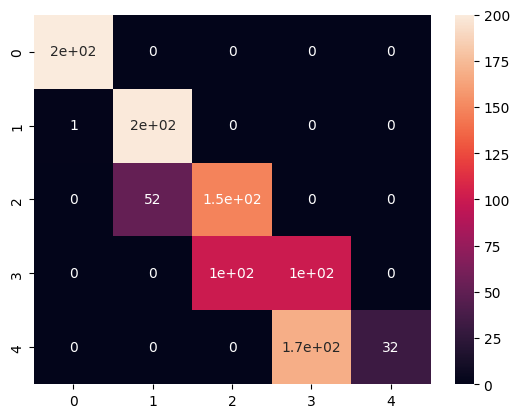

In [37]:
# confusion matrix in heat map

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)

import seaborn as sns
sns.heatmap(cm,annot=True)